In [47]:
import os
import os.path as op 
import pandas as pd
import numpy as np
import gpxpy
import matplotlib.pyplot as plt 
import movingpandas as mpd 

In [48]:
def remove_stops(df, stop_time=20):
    df['del_time'] = df.index.to_series().diff(1).dt.seconds.fillna(0)
    fltr = df['del_time'] < stop_time
    return df.loc[fltr,:]

def add_derived_columns(df):
    df['del_elev'] = df['elev'].diff(1).fillna(0)
    df['total_climb'] = df['del_elev'].clip(0, np.inf).cumsum()
    df['ride_time'] = df['del_time'].cumsum()
    df['ride_distance'] = df['distance'].cumsum()
    return df 

In [49]:
def load_tracks(): 
    all_tracks = [] 
    for d,_,files in os.walk('rides'):
        for idx,f in enumerate(files): 
            print(f)
            path = op.join(d,f)
            with open(path, 'r') as f:
                gpx = gpxpy.parse(f)
            points = gpx.tracks[0].segments[0].points
            points = [ (p.latitude, p.longitude, p.elevation, p.time) for p in points ]
            points = np.array(points)
            df = pd.DataFrame(points[:,:3], index=points[:,3], columns=['lat', 'long', 'elev'])
            t = mpd.Trajectory(df, traj_id=idx, t='time', x='long', y='lat')
            t.add_distance()
            t.df = remove_stops(t.df)
            t.df = add_derived_columns(t.df)
            all_tracks.append(t)

    return sorted(all_tracks, key=lambda t: t.df.index[0])

all_tracks = load_tracks()

TdF_10_Pays_Basque.gpx
TdF_1_Calvados.gpx
TdF_13_Col_de_Tourmalet_Hourquette_d_Ancizan_Lac_de_Cap_de_Long.gpx
TdF_38_Grand_Ballon_Col_de_Hundsruck_Ballon_d_Alsace.gpx
TdF_2_Le_Mans.gpx
TdF_33_Cols_de_T_l_graphe_Madeleine.gpx
TdF_12_Pre_Tourmalet_.gpx
TdF_43_Champagne.gpx
TdF_22_Les_Grandes_Causses.gpx
TdF_8_Les_Landes_de_Gascogne.gpx
TdF_27_Luberon.gpx
TdF_32_Cols_de_Izoard_Lautaret_Galibier.gpx
TdF_26_Ventoux.gpx
TdF_44_Paris.gpx
TdF_17_Gaillac.gpx
TdF_31_Cime_de_la_Bonette_Col_de_Vars.gpx
TdF_29_Cols_de_St_Barnab_Buis_F_lines.gpx
TdF_7_Dordogne.gpx
TdF_35_Gen_ve_Jura_fran_ais_.gpx
TdF_4_Vienne.gpx
TdF_25_Ard_che.gpx
TdFGS_37_Schwarzwald_Alsace.gpx
TdF_28_Verdon.gpx
TdF_16_Haute_Garrone.gpx
TdS_36_Jura_suisse_.gpx
TdF_21_L_Aveyron.gpx
TdF_20_L_Herault.gpx
TdF_39_Petite_Finlande_Haute_Sa_ne.gpx
TdF_30_Cols_de_Valberg_Couillole.gpx
TdF_15_Col_de_Mente_Portet_d_Aspet.gpx
TdF_19_Haut_Languedoc.gpx
TdF_24_Loz_re.gpx
TdF_18_La_Montagne_Noire.gpx
TdF_41_Haute_Marne.gpx
TdF_34_Cols_de_Tami_Ma

In [50]:
all_tracks[0].df.head(5)

,elev,geometry,distance,del_time,del_elev,total_climb,ride_time,ride_distance
2021-09-08 07:30:38+00:00,8.0,POINT (-0.25100 49.27919),0.000000,0.0,0.0,0.0,0.0,0.000000
2021-09-08 07:30:45+00:00,7.0,POINT (-0.25101 49.27911),8.844852,7.0,-1.0,0.0,7.0,8.844852
2021-09-08 07:30:46+00:00,7.0,POINT (-0.25101 49.27911),0.341487,1.0,0.0,0.0,8.0,9.186340
2021-09-08 07:30:47+00:00,7.0,POINT (-0.25101 49.27910),0.468058,1.0,0.0,0.0,9.0,9.654398
2021-09-08 07:30:49+00:00,7.0,POINT (-0.25102 49.27907),3.925712,2.0,0.0,0.0,11.0,13.580109


Text(0.5, 0.98, 'Example original GPX data (without stops)')

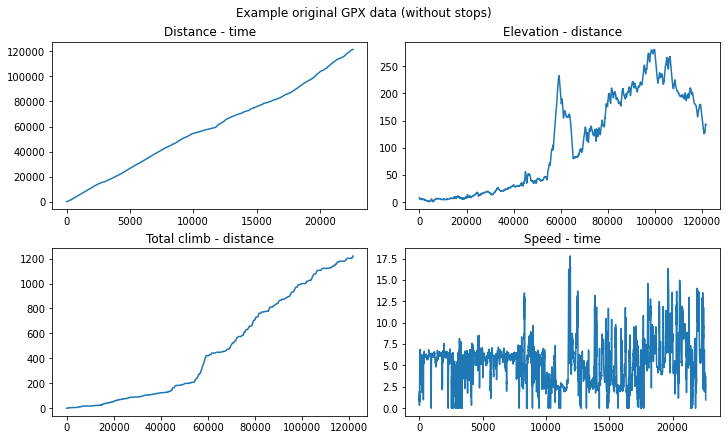

In [51]:
track = all_tracks[0]
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(10,6))

axes[0,0].plot(track.df['ride_time'], track.df['ride_distance'])
axes[0,0].set_title('Distance - time')

axes[0,1].plot(track.df['ride_distance'], track.df['elev'])
axes[0,1].set_title('Elevation - distance')

axes[1,0].plot(track.df['ride_distance'], track.df['total_climb'])
axes[1,0].set_title('Total climb - distance')

axes[1,1].plot(track.df['ride_time'], track.df['distance'] / track.df['del_time'])
axes[1,1].set_title('Speed - time')
fig.suptitle('Example original GPX data (without stops)')

In [52]:
seg_length = 250

def prepare_segments(df, dx):
    n_segs = np.ceil(df['distance'].sum() / dx).astype(int)
    cols = ['time', 'dist', 'climb', 'ride_dist', 'ride_climb', 'altitude', 'long', 'lat']
    segments = np.empty((n_segs, len(cols)), dtype=np.float32)
    segments = pd.DataFrame(segments, columns=cols)
    for idx in range(n_segs):
        low, high = idx * dx, (idx + 1) * dx
        fltr = (df['ride_distance'] >= low) & (df['ride_distance'] < high)
        if not fltr.any(): continue
        deltas = df.loc[fltr,['del_time', 'distance', 'del_elev']].sum(0)
        cumulative = df.loc[fltr,['ride_distance', 'total_climb', 'elev']].iloc[0]
        xy = np.array(df.loc[fltr,'geometry'].iloc[0].coords).squeeze()
        segments.iloc[idx,:] = ((*deltas.values, *cumulative.values, *xy))
        
    segments['speed'] = (segments['dist'] / segments['time']).fillna(0)
    segments['dist_remaining'] = segments['dist'].sum() - segments['ride_dist']
    segments['gradient'] = (100 * segments['climb'] / segments['dist']).fillna(0)
    return segments 

all_segments = []
for tidx,t in enumerate(all_tracks): 
    segs = prepare_segments(t.df, seg_length)
    segs['ride_index'] = tidx 
    all_segments.append(segs)

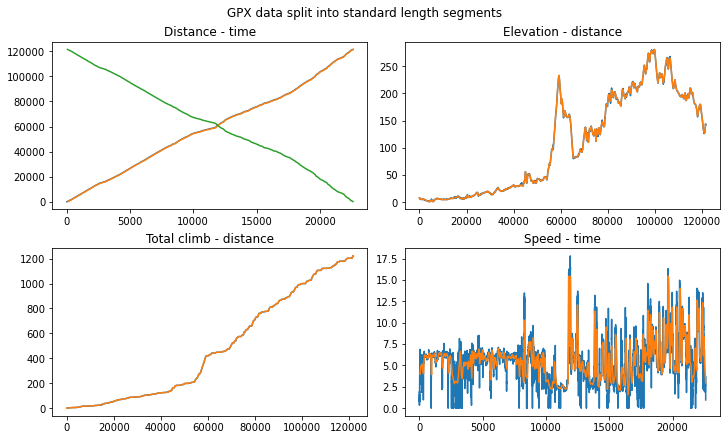

In [53]:
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(10,6))
segments = all_segments[0]

axes[0,0].plot(track.df['ride_time'], track.df['ride_distance'])
axes[0,0].set_title('Distance - time')
axes[0,0].plot(segments['time'].cumsum(), segments['ride_dist'])
axes[0,0].plot(segments['time'].cumsum(), segments['dist_remaining'])

axes[0,1].plot(track.df['ride_distance'], track.df['elev'])
axes[0,1].set_title('Elevation - distance')
axes[0,1].plot(segments['ride_dist'], segments['altitude'])

axes[1,0].plot(track.df['ride_distance'], track.df['total_climb'])
axes[1,0].set_title('Total climb - distance')
axes[1,0].plot(segments['ride_dist'], segments['ride_climb'])

axes[1,1].plot(track.df['ride_time'], track.df['distance'] / track.df['del_time'])
axes[1,1].set_title('Speed - time')
axes[1,1].plot(segments['time'].cumsum(), segments['dist'] / segments['time'])
fig.suptitle('GPX data split into standard length segments')
plt.show()

In [54]:
all_segments = pd.concat(all_segments)
all_segments.head(5)

,time,dist,climb,ride_dist,ride_climb,altitude,long,lat,speed,dist_remaining,gradient,ride_index
0,57.0,227.154648,-2.0,0.000000,0.0,8.0,-0.250998,49.279190,3.985169,121579.171875,-0.880457,0
1,55.0,268.542450,1.0,294.923096,0.0,6.0,-0.254240,49.277710,4.882590,121284.250000,0.372381,0
2,39.0,194.167740,-2.0,504.190460,1.0,7.0,-0.256635,49.276714,4.978660,121074.984375,-1.030037,0
3,54.0,279.313263,1.0,764.858398,2.0,5.0,-0.253993,49.275200,5.172468,120814.312500,0.358021,0
4,62.0,277.870392,0.0,1004.509949,3.0,6.0,-0.253858,49.273312,4.481781,120574.664062,0.000000,0


In [55]:
all_segments.to_hdf('preproc_segments.h5', 'segments', 'w')

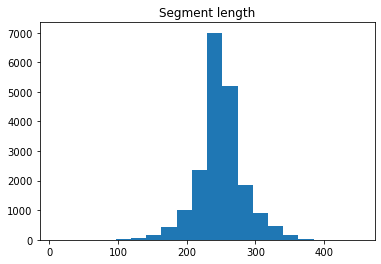

In [56]:
plt.hist(all_segments['dist'], bins=20)
plt.title('Segment length')
plt.show()